Original shape: (768, 9)
Original class counts:
 Outcome
0    500
1    268
Name: count, dtype: int64

After split: Train (614, 9) Test (154, 9)
Train class counts:
 Outcome
0    400
1    214
Name: count, dtype: int64
Test class counts:
 Outcome
0    100
1     54
Name: count, dtype: int64

After SMOTE on TRAIN -> (800, 9)
Train class counts after SMOTE:
 Outcome
0    400
1    400
Name: count, dtype: int64

Training & evaluating: LogisticRegression
Accuracy: 0.714  Precision: 0.581  Recall: 0.667  F1: 0.621  ROC-AUC: 0.808
Confusion Matrix:
 [[74 26]
 [18 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.58      0.67      0.62        54

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.71      0.72       154


Training & evaluating: RandomForest
Accuracy: 0.760  Precision: 0.644  Recall: 0.70

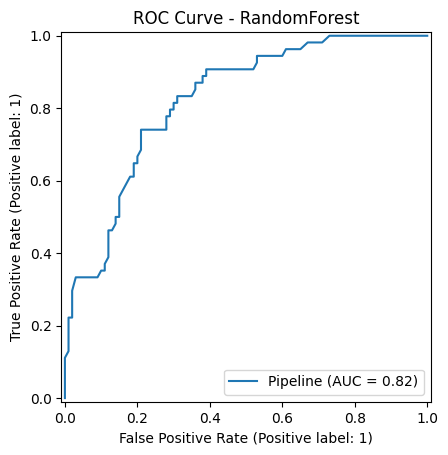


Sanity (SMOTE) train class ratio: {0: 0.5, 1: 0.5}


In [7]:

!pip install -q imbalanced-learn

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay)
import joblib

from imblearn.over_sampling import SMOTE

# -------- Parameters --------
fn_orig = "/content/diabetes.csv"   # path to original dataset
random_state = 42

# -------- Load original data --------
if not os.path.exists(fn_orig):
    raise FileNotFoundError(f"Place the original dataset at {fn_orig} and re-run.")

df = pd.read_csv(fn_orig)
print("Original shape:", df.shape)
print("Original class counts:\n", df['Outcome'].value_counts())

# -------- Preprocessing (replace impossible zeros, median impute) --------
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_proc = df.copy()
for c in cols_with_zero_invalid:
    if c in df_proc.columns:
        df_proc[c] = df_proc[c].replace(0, np.nan)

num_cols = [c for c in df_proc.columns if c != 'Outcome']
imputer = SimpleImputer(strategy='median')
df_proc[num_cols] = imputer.fit_transform(df_proc[num_cols])

# Safe Age_group creation
df_proc['Age'] = df_proc['Age'].fillna(df_proc['Age'].median()).clip(lower=0, upper=120)
df_proc['Age_group'] = pd.cut(df_proc['Age'], bins=[0,30,45,60,120], labels=[0,1,2,3])
df_proc['Age_group'] = df_proc['Age_group'].cat.add_categories([-1]).fillna(-1).astype(int)

# -------- Train-test split (hold-out test) --------
X = df_proc.drop('Outcome', axis=1)
y = df_proc['Outcome'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

print("\nAfter split: Train", X_train.shape, "Test", X_test.shape)
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())

# -------- Apply SMOTE on TRAIN only --------
sm = SMOTE(random_state=random_state)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE on TRAIN ->", X_train_sm.shape)
print("Train class counts after SMOTE:\n", y_train_sm.value_counts())

# -------- Define models --------
models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=random_state))]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=200, random_state=random_state))]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=random_state))])
}
# Try XGBoost if available
try:
    import xgboost as xgb
    models['XGBoost'] = Pipeline([('scaler', StandardScaler()), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state))])
except Exception:
    pass

# -------- Train on SMOTE-augmented TRAIN and evaluate on untouched TEST --------
results = {}
for name, pipe in models.items():
    print(f"\nTraining & evaluating: {name}")
    pipe.fit(X_train_sm, y_train_sm)
    y_pred = pipe.predict(X_test)
    try:
        y_probs = pipe.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_probs = pipe.decision_function(X_test)
        except Exception:
            y_probs = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_probs) if y_probs is not None else None
    results[name] = (acc, prec, rec, f1, roc)
    print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {roc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Choose best by ROC-AUC (fallback to F1)
best_model_name = max(results.items(), key=lambda x: (x[1][4] if x[1][4] is not None else x[1][3]))[0]
print(f"\nBest model on TEST by ROC-AUC/F1 -> {best_model_name}")

# Fit best on full SMOTE-train and save
best_pipe = models[best_model_name]
best_pipe.fit(X_train_sm, y_train_sm)
out_model_path = "/content/best_diabetes_model_smote.joblib"
joblib.dump(best_pipe, out_model_path)
print("Saved best model to:", out_model_path)

# Plot ROC for best model if probabilities available
try:
    RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
    plt.title(f"ROC Curve - {best_model_name}")
    plt.show()
except Exception:
    pass

# Quick sanity check: class balance in SMOTE set
print("\nSanity (SMOTE) train class ratio:", y_train_sm.value_counts(normalize=True).to_dict())





